# 12 · Métricas de calidad con ruido y filtrado (MSE, PSNR, SSIM)




## 1) Definiciones matemáticas

Sea una imagen original \(I\) de tamaño \(M $\times$ N\) (**alto** \(M\), **ancho** \(N\)) y su versión procesada \($\hat{I}$\). Usamos índices de píxel \((x,y)\) con \(0 $\le$ x < M\) y \(0 $\le$ y < N\).

### 1.1 MSE — *Mean Squared Error*
$$
\mathrm{MSE} \;=\; \frac{1}{MN} \sum_{x=0}^{M-1}\sum_{y=0}^{N-1} \big( I(x,y) - \hat{I}(x,y) \big)^2
$$
**Variables:**  
- \(M, N\): dimensiones de la imagen (alto y ancho).  
- \(I(x,y)\): intensidad del píxel original en \((x,y)\).  
- \($\hat{I}$(x,y)\): intensidad del píxel procesado en \((x,y)\).

### 1.2 PSNR — *Peak Signal-to-Noise Ratio*
$$
\mathrm{PSNR} \;=\; 10 \cdot \log_{10}\!\left( \frac{L^2}{\mathrm{MSE}} \right)
$$
**Variables:**  
- \(L\): **valor máximo de intensidad** permitido por el formato (p.ej., \(L=255\) en **8 bits**, \(L=65535\) en **16 bits**).  
- Mientras **mayor** el PSNR (dB), **mejor** la calidad.

### 1.3 SSIM — *Structural Similarity Index*
$$
\mathrm{SSIM}(I,\hat{I}) \;=\; \frac{(2\mu_I\,\mu_{\hat{I}} + C_1)(2\sigma_{I\hat{I}} + C_2)}{(\mu_I^2 + \mu_{\hat{I}}^2 + C_1)(\sigma_I^2 + \sigma_{\hat{I}}^2 + C_2)}
$$
**Variables:**  
- \($\mu_I$, $\mu_{\hat{I}}$\): medias **locales**.  
- \($\sigma_I^2$, $\sigma_{\hat{I}}^2$\): varianzas **locales**.  
- \($\sigma_{I\hat{I}}$\): **covarianza local**.  
- \($C_1 = (k_1 L)^2$\), \($C_2 = (k_2 L)^2$\) con típicos \($k_1 = 0.01$\), \($k_2 = 0.03$\).  
- SSIM se evalúa por ventanas y luego se **promedia** en toda la imagen. Su rango práctico es \([0,1]\) (1 = idénticas).

> **Nota:** Para SSIM usaremos la **luminancia** (imagen en escala de grises).


## 2) Librerías y funciones auxiliares

In [13]:
import cv2, numpy as np, matplotlib.pyplot as plt

# Para reproducibilidad ligera
np.random.seed(7)

# --- Rango dinámico (L) según dtype/valores ---
def infer_L_from_dtype(img):
    if np.issubdtype(img.dtype, np.integer):
        info = np.iinfo(img.dtype)
        return float(info.max)  # 255 para uint8, 65535 para uint16, etc.
    vmax = float(np.max(img))
    return 255.0 if vmax > 1.0 else 1.0

# --- Métricas ---
def mse(a, b):
    a = a.astype(np.float64); b = b.astype(np.float64)
    return float(np.mean((a - b) ** 2))

def psnr(a, b, L=None):
    m = mse(a, b)
    if m == 0:
        return float('inf')
    if L is None:
        L = infer_L_from_dtype(a)
    return 10.0 * np.log10((L * L) / m)

def ssim_gray(img1, img2, L=None, k1=0.01, k2=0.03, win_size=11, sigma=1.5):
    # Implementación clásica (Wang et al. 2004) sobre gris
    if L is None:
        L = infer_L_from_dtype(img1)
    X = img1.astype(np.float32)
    Y = img2.astype(np.float32)
    muX = cv2.GaussianBlur(X, (win_size, win_size), sigma)
    muY = cv2.GaussianBlur(Y, (win_size, win_size), sigma)
    muX2 = muX * muX; muY2 = muY * muY; muXY = muX * muY
    sigmaX2 = cv2.GaussianBlur(X * X, (win_size, win_size), sigma) - muX2
    sigmaY2 = cv2.GaussianBlur(Y * Y, (win_size, win_size), sigma) - muY2
    sigmaXY = cv2.GaussianBlur(X * Y, (win_size, win_size), sigma) - muXY
    C1 = (k1 * L) ** 2; C2 = (k2 * L) ** 2
    num = (2 * muX * muY + C1) * (2 * sigmaXY + C2)
    den = (muX2 + muY2 + C1) * (sigmaX2 + sigmaY2 + C2)
    ssim_map = num / (den + 1e-12)
    return float(np.mean(ssim_map))

def to_gray_uint(img_rgb):
    # Asegura uint8/uint16 y convierte a gris
    if img_rgb.dtype in (np.float32, np.float64):
        tmp = np.clip(img_rgb, 0, 255).astype(np.uint8)
    else:
        tmp = img_rgb
    return cv2.cvtColor(tmp, cv2.COLOR_RGB2GRAY)

## 3) Carga de imagen y generación de ruido

Formato detectado: dtype=uint8, L=255.0, bits≈8


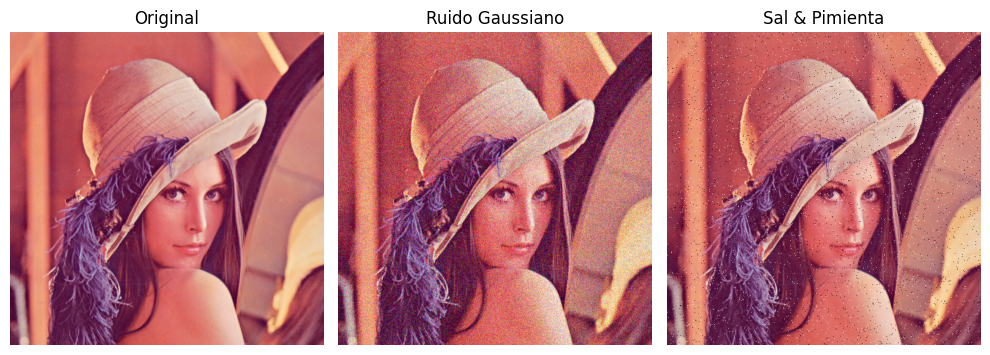

In [14]:
# Cargar imagen
IMG_PATH = r"C:\Users\20808\Documents\Repositorios\Vision_en_Robotica\imagenes\lenna.png"  # Ajusta si es necesario
img_bgr = cv2.imread(IMG_PATH, cv2.IMREAD_UNCHANGED)
if img_bgr is None:
    raise FileNotFoundError(f"No se pudo cargar la imagen en {IMG_PATH}.")
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

# Detectar L y bits desde la imagen real
L_detected = infer_L_from_dtype(img_rgb)
bits = 8 if L_detected <= 255 else 16
print(f"Formato detectado: dtype={img_rgb.dtype}, L={L_detected}, bits≈{bits}")

# Definir ruidos
def add_gaussian_noise(img, mean=0.0, sigma=25.0):
    noise = np.random.normal(mean, sigma, img.shape).astype(np.float32)
    out = img.astype(np.float32) + noise
    return np.clip(out, 0, L_detected).astype(img.dtype)

def add_salt_pepper(img, prob=0.02):
    rng = np.random.default_rng(7)  # determinista
    noisy = img.copy()
    h, w = noisy.shape[:2]
    mask = rng.random((h, w))
    if noisy.ndim == 2:
        noisy[mask < prob/2] = 0
        noisy[mask > 1 - prob/2] = L_detected
    else:
        for c in range(noisy.shape[2]):
            ch = noisy[..., c]
            ch[mask < prob/2] = 0
            ch[mask > 1 - prob/2] = L_detected
            noisy[..., c] = ch
    return noisy

# Generar imágenes ruidosas
gauss_sigma = 25 if bits==8 else 1000
img_gauss = add_gaussian_noise(img_rgb, sigma=gauss_sigma)
img_sp    = add_salt_pepper(img_rgb, prob=0.02)

# Vista rápida
plt.figure(figsize=(10,4))
plt.subplot(1,3,1); plt.imshow(img_rgb);   plt.title("Original");        plt.axis("off")
plt.subplot(1,3,2); plt.imshow(img_gauss); plt.title("Ruido Gaussiano"); plt.axis("off")
plt.subplot(1,3,3); plt.imshow(img_sp);    plt.title("Sal & Pimienta");  plt.axis("off")
plt.tight_layout(); plt.show()

## 4) Aplicación de filtros (media, mediana, gaussiano)

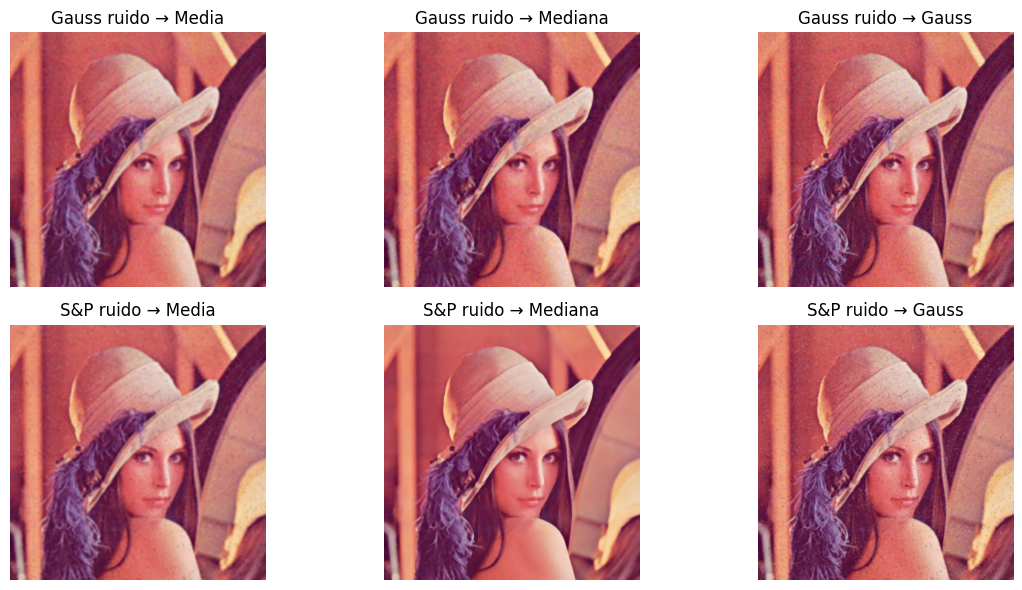

In [15]:
# Parámetros de filtros
k = 5  # tamaño de kernel impar
sigma_g = 1.0

img_gauss_mean   = cv2.blur(img_gauss, (k,k))
img_gauss_median = cv2.medianBlur(img_gauss, k)
img_gauss_gauss  = cv2.GaussianBlur(img_gauss, (k,k), sigma_g)

img_sp_mean      = cv2.blur(img_sp, (k,k))
img_sp_median    = cv2.medianBlur(img_sp, k)
img_sp_gauss     = cv2.GaussianBlur(img_sp, (k,k), sigma_g)

# Mostrar
plt.figure(figsize=(12,6))
plt.subplot(2,3,1); plt.imshow(img_gauss_mean);   plt.title("Gauss ruido → Media");   plt.axis("off")
plt.subplot(2,3,2); plt.imshow(img_gauss_median); plt.title("Gauss ruido → Mediana"); plt.axis("off")
plt.subplot(2,3,3); plt.imshow(img_gauss_gauss);  plt.title("Gauss ruido → Gauss");   plt.axis("off")

plt.subplot(2,3,4); plt.imshow(img_sp_mean);      plt.title("S&P ruido → Media");     plt.axis("off")
plt.subplot(2,3,5); plt.imshow(img_sp_median);    plt.title("S&P ruido → Mediana");   plt.axis("off")
plt.subplot(2,3,6); plt.imshow(img_sp_gauss);     plt.title("S&P ruido → Gauss");     plt.axis("off")
plt.tight_layout(); plt.show()

## 5) Cálculo de métricas (MSE, PSNR, SSIM) y tabla Markdown

In [16]:
from IPython.display import Markdown, display

# Convertir a gris para SSIM
orig_gray   = to_gray_uint(img_rgb)
gauss_gray  = to_gray_uint(img_gauss)
sp_gray     = to_gray_uint(img_sp)
g_mean_gray = to_gray_uint(img_gauss_mean)
g_med_gray  = to_gray_uint(img_gauss_median)
g_gau_gray  = to_gray_uint(img_gauss_gauss)
s_mean_gray = to_gray_uint(img_sp_mean)
s_med_gray  = to_gray_uint(img_sp_median)
s_gau_gray  = to_gray_uint(img_sp_gauss)

# Cálculo de métricas
rows = []

def add_row(name, A_rgb, B_rgb, A_gray, B_gray):
    L_here = infer_L_from_dtype(A_rgb)
    rows.append({
        "Comparación": name,
        "MSE":  mse(A_rgb, B_rgb),
        "PSNR_dB": psnr(A_rgb, B_rgb, L=L_here),
        "SSIM_gray": ssim_gray(A_gray, B_gray, L=L_here)
    })

# Contra ruido
add_row("Original vs Gauss ruidosa", img_rgb, img_gauss, orig_gray, gauss_gray)
add_row("Original vs S&P ruidosa",   img_rgb, img_sp,    orig_gray, sp_gray)

# Contra filtros (sobre gauss)
add_row("Original vs (Gauss→Media)",   img_rgb, img_gauss_mean,   orig_gray, g_mean_gray)
add_row("Original vs (Gauss→Mediana)", img_rgb, img_gauss_median, orig_gray, g_med_gray)
add_row("Original vs (Gauss→Gauss)",   img_rgb, img_gauss_gauss,  orig_gray, g_gau_gray)

# Contra filtros (sobre S&P)
add_row("Original vs (S&P→Media)",     img_rgb, img_sp_mean,   orig_gray, s_mean_gray)
add_row("Original vs (S&P→Mediana)",   img_rgb, img_sp_median, orig_gray, s_med_gray)
add_row("Original vs (S&P→Gauss)",     img_rgb, img_sp_gauss,  orig_gray, s_gau_gray)

# Construir tabla
headers = ["Comparación", "MSE", "PSNR (dB)", "SSIM"]
md = ["| " + " | ".join(headers) + " |",
      "| " + " | ".join(["---"]*len(headers)) + " |"]

for r in rows:
    md.append("| " + " | ".join([
        r["Comparación"],
        f"{r['MSE']:.2f}",
        f"{r['PSNR_dB']:.2f}",
        f"{r['SSIM_gray']:.4f}",
    ]) + " |")

display(Markdown("\n".join(md)))

# --- Resumen: mejor filtro por tipo de ruido (según SSIM y PSNR) ---
def best_for(prefix):
    subset = [row for row in rows if row["Comparación"].startswith(prefix)]
    # SSIM max
    best_ssim = max(subset, key=lambda x: x["SSIM_gray"])
    # PSNR max
    best_psnr = max(subset, key=lambda x: x["PSNR_dB"])
    return best_ssim, best_psnr

best_g_ssim, best_g_psnr = best_for("Original vs (Gauss")
best_sp_ssim, best_sp_psnr = best_for("Original vs (S&P")

summary_lines = [
    "### 6) Resumen interpretativo",
    "- **Ruido Gaussiano:**",
    f"  - Mejor **SSIM**: `{best_g_ssim['Comparación']}` (SSIM={best_g_ssim['SSIM_gray']:.4f}, PSNR={best_g_ssim['PSNR_dB']:.2f} dB)",
    f"  - Mejor **PSNR**: `{best_g_psnr['Comparación']}` (PSNR={best_g_psnr['PSNR_dB']:.2f} dB, SSIM={best_g_psnr['SSIM_gray']:.4f})",
    "- **Ruido Sal & Pimienta:**",
    f"  - Mejor **SSIM**: `{best_sp_ssim['Comparación']}` (SSIM={best_sp_ssim['SSIM_gray']:.4f}, PSNR={best_sp_ssim['PSNR_dB']:.2f} dB)",
    f"  - Mejor **PSNR**: `{best_sp_psnr['Comparación']}` (PSNR={best_sp_psnr['PSNR_dB']:.2f} dB, SSIM={best_sp_psnr['SSIM_gray']:.4f})",
    "",
    "**Regla práctica:** con **ruido Gaussiano** suele funcionar mejor el **filtro Gaussiano** (o media); con **Sal & Pimienta** la **mediana** tiende a conservar mejor estructura (SSIM).",
]
display(Markdown("\n".join(summary_lines)))

| Comparación | MSE | PSNR (dB) | SSIM |
| --- | --- | --- | --- |
| Original vs Gauss ruidosa | 598.36 | 20.36 | 0.4135 |
| Original vs S&P ruidosa | 382.99 | 22.30 | 0.6077 |
| Original vs (Gauss→Media) | 103.83 | 27.97 | 0.7918 |
| Original vs (Gauss→Mediana) | 106.45 | 27.86 | 0.7726 |
| Original vs (Gauss→Gauss) | 88.47 | 28.66 | 0.8043 |
| Original vs (S&P→Media) | 95.59 | 28.33 | 0.7841 |
| Original vs (S&P→Mediana) | 57.26 | 30.55 | 0.8651 |
| Original vs (S&P→Gauss) | 70.75 | 29.63 | 0.8018 |

### 6) Resumen interpretativo
- **Ruido Gaussiano:**
  - Mejor **SSIM**: `Original vs (Gauss→Gauss)` (SSIM=0.8043, PSNR=28.66 dB)
  - Mejor **PSNR**: `Original vs (Gauss→Gauss)` (PSNR=28.66 dB, SSIM=0.8043)
- **Ruido Sal & Pimienta:**
  - Mejor **SSIM**: `Original vs (S&P→Mediana)` (SSIM=0.8651, PSNR=30.55 dB)
  - Mejor **PSNR**: `Original vs (S&P→Mediana)` (PSNR=30.55 dB, SSIM=0.8651)

**Regla práctica:** con **ruido Gaussiano** suele funcionar mejor el **filtro Gaussiano** (o media); con **Sal & Pimienta** la **mediana** tiende a conservar mejor estructura (SSIM).